In [1]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.optimize import brentq

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", "{:.4f}".format)

In [3]:
from nsepython import nse_get_index_quote
import time

time.sleep(1)

spot_data = nse_get_index_quote("NIFTY 50")
S = float(spot_data["last"].replace(",", ""))

assert S > 0
print(f"NIFTY Spot Price: {S}")


NIFTY Spot Price: 25748.9


In [5]:
FILE_PATH = "23 Dec Option chain.xlsx"

# Second row contains actual column names
df = pd.read_excel(FILE_PATH, header=1)
df = df.dropna(axis=1, how="all")

df.head()


,OI,Chng in OI,Volume,IV,LTP,Chng,Bid Qty,Bid,Ask,Ask Qty,Strike,Bid Qty.1,Bid.1,Ask.1,Ask Qty.1,Chng.1,LTP.1,IV.1,Volume.1,Chng in OI.1,OI.1
0,947,13,25,46.1600,1980,145.1000,750,1912.9500,1972.6500,375,24000,"1,68,150",1.3000,1.3500,"2,70,675",-0.1000,1.3000,29.5400,"1,16,550",17135,89912
1,2,-,-,-,-,-,750,1863.2000,1933.0000,75,24050,72600,1.3500,1.4000,51825,-0.0500,1.4000,28.9600,14683,1688,3837
2,2,-,-,-,-,-,750,1805.5000,1880.8500,75,24100,75300,1.4500,1.5000,"1,12,500",-,1.5000,28.4900,27592,-136,9904
3,5,-,3,36.3600,1831.5000,46.5000,75,1805.5500,1827.9500,150,24150,52425,1.5000,1.5500,51825,-,1.5500,27.7900,10666,749,2543
4,34,-,1,-,1730.8000,5.8000,150,1756.8000,1771.7000,75,24200,58275,1.6000,1.6500,"1,43,250",0.0500,1.6000,27.1900,42470,2114,13735


In [7]:
df["Strike"] = (
    df["Strike"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)


In [9]:
calls = df[[
    "Strike", "Bid", "Ask", "LTP", "IV", "OI", "Volume"
]].copy()

calls["option_type"] = "CALL"

In [11]:
puts = df[[
    "Strike", "Bid.1", "Ask.1", "LTP.1", "IV.1", "OI.1", "Volume.1"
]].copy()

puts["option_type"] = "PUT"

In [13]:
calls.columns = ["strike", "bid", "ask", "ltp", "iv_nse", "oi", "volume", "option_type"]
puts.columns  = ["strike", "bid", "ask", "ltp", "iv_nse", "oi", "volume", "option_type"]

In [15]:
def best_price(row):
    if row["bid"] > 0 and row["ask"] > 0:
        return 0.5 * (row["bid"] + row["ask"])
    return row["ltp"]

calls["price"] = calls.apply(best_price, axis=1)
puts["price"]  = puts.apply(best_price, axis=1)

In [17]:
options = pd.concat([calls, puts], ignore_index=True)
options = options.dropna(subset=["price"])
options.head()

,strike,bid,ask,ltp,iv_nse,oi,volume,option_type,price
0,24000.0000,1912.9500,1972.6500,1980,46.1600,947,25,CALL,1942.8000
1,24050.0000,1863.2000,1933.0000,-,-,2,-,CALL,1898.1000
2,24100.0000,1805.5000,1880.8500,-,-,2,-,CALL,1843.1750
3,24150.0000,1805.5500,1827.9500,1831.5000,36.3600,5,3,CALL,1816.7500
4,24200.0000,1756.8000,1771.7000,1730.8000,-,34,1,CALL,1764.2500


In [19]:
R = 0.065  # risk-free rate

valuation_date = pd.Timestamp("2023-12-23")
expiry_date    = pd.Timestamp("2023-12-28")

T = (expiry_date - valuation_date).days / 365
assert T > 0

In [21]:
options = options[
    (options["strike"] >= 0.9 * S) &
    (options["strike"] <= 1.1 * S)
]

In [23]:
def bs_price(S, K, T, r, sigma, opt):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if opt == "CALL":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


In [25]:
def implied_vol(price, S, K, T, r, opt):
    if price <= 0:
        return np.nan
    try:
        return brentq(
            lambda vol: bs_price(S, K, T, r, vol, opt) - price,
            1e-6, 5.0
        )
    except:
        return np.nan


In [27]:
options["iv_model"] = options.apply(
    lambda x: implied_vol(
        x["price"], S, x["strike"], T, R, x["option_type"]
    ),
    axis=1
)


In [29]:
options["moneyness"] = options["strike"] / S

atm_options = options[
    (options["moneyness"] >= 0.99) &
    (options["moneyness"] <= 1.01)
]

sigma_atm = atm_options["iv_model"].median()

print(f"ATM Implied Volatility: {sigma_atm:.4f}")


ATM Implied Volatility: 0.1494


In [31]:
options["bs_price_atm"] = options.apply(
    lambda x: bs_price(
        S, x["strike"], T, R, sigma_atm, x["option_type"]
    ),
    axis=1
)


In [33]:
options["abs_error"] = abs(options["bs_price_atm"] - options["price"])

mae  = options["abs_error"].mean()
rmse = np.sqrt((options["abs_error"] ** 2).mean())

print(f"ATM-BS MAE  : {mae:.2f}")
print(f"ATM-BS RMSE : {rmse:.2f}")


ATM-BS MAE  : 102.49
ATM-BS RMSE : 138.58


In [35]:
def greeks(S, K, T, r, sigma, opt):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    delta = norm.cdf(d1) if opt == "CALL" else norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega  = S * norm.pdf(d1) * np.sqrt(T)

    return delta, gamma, vega


In [37]:
options[["delta", "gamma", "vega"]] = options.apply(
    lambda x: greeks(
        S, x["strike"], T, R, sigma_atm, x["option_type"]
    ),
    axis=1,
    result_type="expand"
)


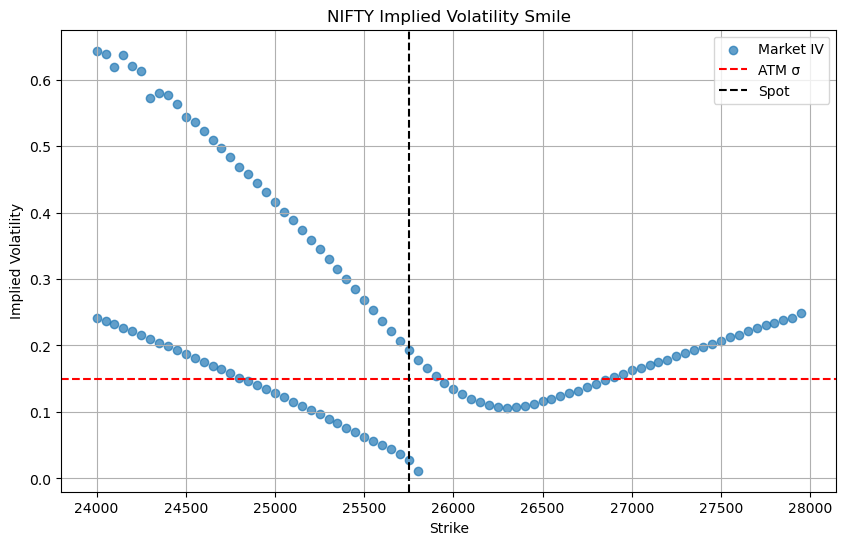

In [39]:
plt.figure(figsize=(10,6))
plt.scatter(options["strike"], options["iv_model"], alpha=0.7, label="Market IV")
plt.axhline(sigma_atm, color="red", linestyle="--", label="ATM σ")
plt.axvline(S, color="black", linestyle="--", label="Spot")

plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("NIFTY Implied Volatility Smile")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
import os

RESULTS_DIR = "results_BS"
os.makedirs(RESULTS_DIR, exist_ok=True)

# ---- Save results table ----
results_path = os.path.join(RESULTS_DIR, "nifty_bs_atm_results.csv")
options.to_csv(results_path, index=False)

# ---- IV Smile Plot ----
plt.figure(figsize=(10,6))
plt.scatter(options["strike"], options["iv_model"], alpha=0.7, label="Market IV")
plt.axhline(sigma_atm, color="red", linestyle="--", label="ATM σ")
plt.axvline(S, color="black", linestyle="--", label="Spot")

plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("NIFTY Implied Volatility Smile")
plt.legend()
plt.grid(True)

smile_plot_path = os.path.join(RESULTS_DIR, "iv_smile.png")
plt.savefig(smile_plot_path, dpi=150, bbox_inches="tight")
plt.close()

# ---- Error vs Moneyness Plot ----
plt.figure(figsize=(10,6))
plt.scatter(options["moneyness"], options["abs_error"], alpha=0.7)
plt.xlabel("Moneyness (K / S)")
plt.ylabel("Absolute Pricing Error")
plt.title("Black–Scholes Pricing Error vs Moneyness")
plt.grid(True)

error_plot_path = os.path.join(RESULTS_DIR, "pricing_error_vs_moneyness.png")
plt.savefig(error_plot_path, dpi=150, bbox_inches="tight")
plt.close()

print("Saved outputs:")
print(f"- {results_path}")
print(f"- {smile_plot_path}")
print(f"- {error_plot_path}")


Saved outputs:
- results_BS\nifty_bs_atm_results.csv
- results_BS\iv_smile.png
- results_BS\pricing_error_vs_moneyness.png
